In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from operator import add
import os
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.ticker import FixedLocator
import matplotlib.font_manager


sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.8, rc=paper_rc)
current_palette = sns.color_palette()
cmp = sns.color_palette("tab10")

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.1f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 4),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=14,
        )
    
def autolabel_h(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(
            "%.2f" % width,
            xy=(width, rect.get_y() + rect.get_height() / 2),
            xytext=(18, -1),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="center",
            size=13,
        )

SAVEPATH = './'
os.makedirs(SAVEPATH, exist_ok=True)

# DCGM data process

In [11]:
log = pd.read_csv('/home/mzhang/work/TiGraph/dcgmi_logs/revgcn/first_small4_then_pp4.log', sep='\s\s+', engine='python')
log.to_csv('/home/mzhang/work/TiGraph/dcgmi_logs/test.csv', index=None, mode='w')
df = pd.read_csv('/home/mzhang/work/TiGraph/dcgmi_logs/test.csv')
# df.dropna(axis=0, how='any', inplace=True)  
df = df[df['#Entity'] == 'GPU 2']
df

,#Entity,SMACT,SMOCC,GPUTL,MCUTL,DRAMA,NVLTX,NVLRX,PCITX,PCIRX
2,GPU 2,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
6,GPU 2,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
10,GPU 2,0.000,0.000,0,0,0.000,0,NaN,995874,411906
14,GPU 2,0.000,0.000,0,0,0.000,0,0,995874,411906
18,GPU 2,0.000,NaN,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
19340,GPU 2,0.513,0.244,100,13,0.101,0,0,45156263,67968608
19344,GPU 2,NaN,NaN,100,13,NaN,NaN,NaN,NaN,NaN
19348,GPU 2,0.511,0.245,100,13,0.100,0,0,43984486,66338538
19352,GPU 2,NaN,NaN,100,13,NaN,NaN,NaN,NaN,NaN


In [12]:
# Transfer all data to numeric
cols = df.columns.drop('#Entity')
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# For rows where GPUTL != 0 and SMACT is NaN, fill SMACT with the previous valid value
mask = (df['GPUTL'] != 0) & (df['SMACT'].isna())
df.loc[mask, 'SMACT'] = df['SMACT'].ffill()[mask]

# Drop only rows where SMACT is still NaN
df = df.dropna(subset=['SMACT'])

df

,#Entity,SMACT,SMOCC,GPUTL,MCUTL,DRAMA,NVLTX,NVLRX,PCITX,PCIRX
10,GPU 2,0.000,0.000,0,0,0.000,0.0,NaN,995874.0,411906.0
14,GPU 2,0.000,0.000,0,0,0.000,0.0,0.0,995874.0,411906.0
18,GPU 2,0.000,NaN,0,0,NaN,NaN,NaN,NaN,NaN
26,GPU 2,0.000,NaN,0,0,NaN,NaN,NaN,NaN,NaN
34,GPU 2,0.000,0.000,0,0,0.000,NaN,NaN,2836405.0,NaN
...,...,...,...,...,...,...,...,...,...,...
19340,GPU 2,0.513,0.244,100,13,0.101,0.0,0.0,45156263.0,67968608.0
19344,GPU 2,0.513,NaN,100,13,NaN,NaN,NaN,NaN,NaN
19348,GPU 2,0.511,0.245,100,13,0.100,0.0,0.0,43984486.0,66338538.0
19352,GPU 2,0.511,NaN,100,13,NaN,NaN,NaN,NaN,NaN


In [13]:
file_csv = '/home/mzhang/work/TiGraph/dcgmi_logs/revgcn/revgcn_small4_pp4_gpu2_util.csv'
# if os.path.exists(file_csv):
df.to_csv(file_csv, mode='w')

In [5]:
df.index

Index([  12,   16,   20,   24,   28,   32,   36,   40,   44,   48,
       ...
       5874, 5878, 5882, 5886, 5890, 5894, 5898, 5902, 5906, 5910],
      dtype='int64', length=1357)

# RevGCN

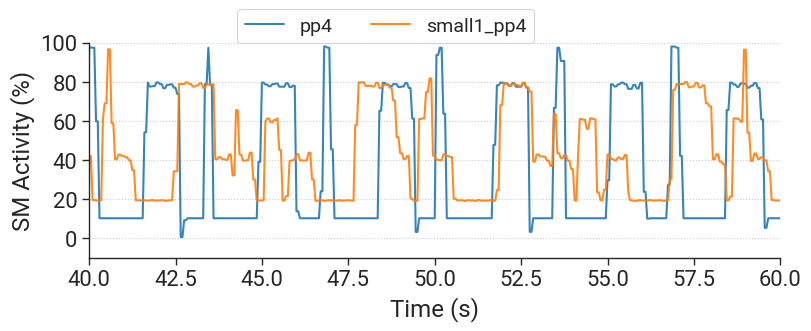

In [9]:
import warnings
warnings.filterwarnings("ignore")
params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

# Figure 1
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_pp4_gpu1_util.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_small4_pp4_gpu1_util.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values*50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values-1695)*50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
# pp4_smact = np.where(pp4_smact > 90, 82, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)
pp4_smocc = df_pp4_gpu0['SMOCC']*100
pp4_gputil = df_pp4_gpu0['GPUTL']

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
# small1_pp4_smact = np.where(small1_pp4_smact > 90, 82, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

ax1.plot(x_pp4, pp4_smact, label='pp4', linewidth=1.5, color=cmp[0], alpha=0.9)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=1.5, color=cmp[1], alpha=0.9)

ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(40, 60)
# ax1.set_xticks(np.arange(2,22,1))
ax1.grid(axis="y", linestyle=":")
# ax1.set_title('Resnet18, bs=512, scale=8')
sns.despine()
ax1.legend(loc=2, 
           ncol=3,
           bbox_to_anchor=(0.2, 1.2), fontsize=14, frameon=True)
save = False
if save:
    fig.savefig(f"./figures/util_trace.pdf", bbox_inches="tight")

# RevGCN fix

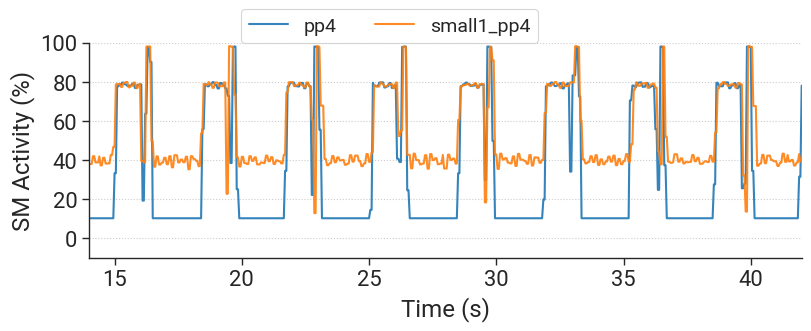

In [76]:
import warnings
warnings.filterwarnings("ignore")
params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

# Figure 1
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_pp4_gpu0_util_v2.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_small1_pp4_gpu0_util_v2.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values*50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values-364)*50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
# pp4_smact = np.where(pp4_smact > 90, 82, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
# small1_pp4_smact = np.where(small1_pp4_smact > 90, 82, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

ax1.plot(x_pp4, pp4_smact, label='pp4', linewidth=1.5, color=cmp[0], alpha=0.9)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=1.5, color=cmp[1], alpha=0.9)

ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(14, 42)
# ax1.set_xticks(np.arange(30,80,3))
ax1.grid(axis="y", linestyle=":")
# ax1.set_title('Resnet18, bs=512, scale=8')
sns.despine()
ax1.legend(loc=2, 
           ncol=3,
           bbox_to_anchor=(0.2, 1.2), fontsize=14, frameon=True)
save = False
if save:
    fig.savefig(f"./figures/util_trace.pdf", bbox_inches="tight")

In [35]:
df_small1_pp4_gpu0

,Unnamed: 0,#Entity,SMACT,SMOCC,GPUTL,MCUTL,DRAMA,NVLTX,NVLRX,PCITX,PCIRX
0,16,GPU 0,0.767,0.437,91,23,0.171,0.0,0.0,15010745.0,112081618.0
1,20,GPU 0,0.767,NaN,92,23,NaN,NaN,NaN,NaN,NaN
2,24,GPU 0,0.732,0.418,92,23,0.191,0.0,0.0,17741656.0,149622684.0
3,28,GPU 0,0.732,NaN,92,23,NaN,NaN,NaN,NaN,NaN
4,32,GPU 0,0.764,0.415,92,22,0.170,0.0,0.0,15656122.0,117075374.0
...,...,...,...,...,...,...,...,...,...,...,...
3355,14018,GPU 0,0.393,0.190,100,11,0.076,0.0,0.0,41348070.0,98691768.0
3356,14022,GPU 0,0.393,NaN,100,10,NaN,NaN,NaN,NaN,NaN
3357,14026,GPU 0,0.412,0.224,100,10,0.079,0.0,0.0,40993914.0,92913289.0
3358,14030,GPU 0,0.412,NaN,100,10,NaN,NaN,NaN,NaN,NaN


# RevGAT

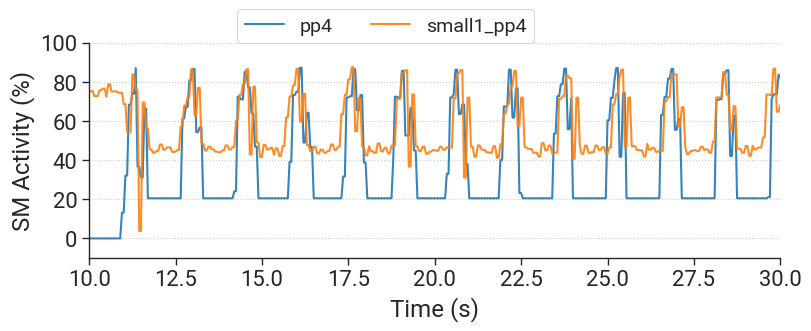

In [101]:
import warnings
warnings.filterwarnings("ignore")
params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

# Figure 1
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_pp4_gpu0_util_v2.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_small1_pp4_gpu0_util_v2.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values[:] * 50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values[:] - 401) * 50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
pp4_smact = np.where(pp4_smact > 90, 80, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)
pp4_smocc = df_pp4_gpu0['SMOCC']*100
pp4_gputil = df_pp4_gpu0['GPUTL']

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
small1_pp4_smact = np.where(small1_pp4_smact > 90, 80, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

ax1.plot(x_pp4, pp4_smact, label='pp4', linewidth=1.5, color=cmp[0], alpha=0.9)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=1.5, color=cmp[1], alpha=0.9)

ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(10, 30)
# ax1.set_xticks(np.arange(20,40,1))
ax1.grid(axis="y", linestyle=":")
# ax1.set_title('RevGAT')
sns.despine()
ax1.legend(loc=2, 
           ncol=3,
           bbox_to_anchor=(0.2, 1.2), fontsize=14, frameon=True)
save = False
if save:
    fig.savefig(f"./figures/util_trace.pdf", bbox_inches="tight")

# RevGAT small4 then pp4

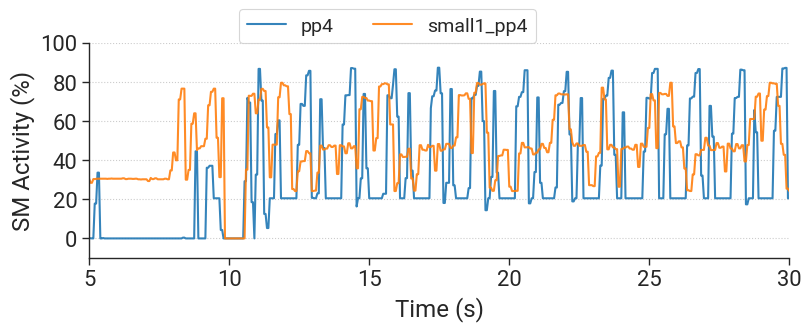

In [3]:
import warnings
warnings.filterwarnings("ignore")
params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

# Figure 1
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_pp4_gpu1_util.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_small4_pp4_gpu1_util.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values[:] * 50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values[:]-311) * 50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
pp4_smact = np.where(pp4_smact > 90, 80, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)
pp4_smocc = df_pp4_gpu0['SMOCC']*100
pp4_gputil = df_pp4_gpu0['GPUTL']

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
small1_pp4_smact = np.where(small1_pp4_smact > 90, 80, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

ax1.plot(x_pp4, pp4_smact, label='pp4', linewidth=1.5, color=cmp[0], alpha=0.9)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=1.5, color=cmp[1], alpha=0.9)

ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(5, 30)
# ax1.set_xticks(np.arange(20,40,1))
ax1.grid(axis="y", linestyle=":")
# ax1.set_title('RevGAT')
sns.despine()
ax1.legend(loc=2, 
           ncol=3,
           bbox_to_anchor=(0.2, 1.2), fontsize=14, frameon=True)

save = False
if save:
    fig.savefig(f"./figures/util_trace.pdf", bbox_inches="tight")